# training to predict the error

1. Changes to the train function where we will now be predicting the error and then using it to compute the loss
2. Changes to the generator where we are going to remove the predicted error to obtain the true distribution
3. we will also do some minor improvements and optimizations:
    1. sampling from normal distribution
    2. using model sequence to write the pytorch model
    3. <font color='red'> (Todo:) Use GPU? </font>
    4. clipping to improve stabalization
<p> </p> 
4.  Energy function interpretation and the error function interpretation are very similar. We will point out in the code changes to train and generate function for energy function interpretaion 

<p> Error prediction sampling equation </p>

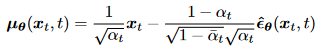

<p> Error prediction training equation </p>

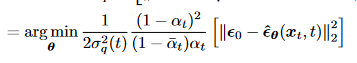

<p> Energy function sampling equation </p>

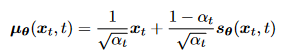

<p> Energy function training equation </p>

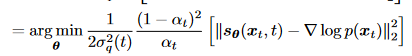


# issues

1. There is an issue with the generation of samples. At timestep t=T alpha_===1. which makes the mu(x_T)=inf. Could either restrict alphas in a way so that alpha_ at T is < 1 or apply some other techniques to get numerical stability. 
</br>
<font color='red'> Investigating clipping to fix this --  https://github.com/hojonathanho/diffusion/issues/5 </font>


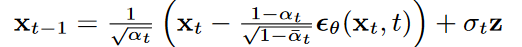

2. I am not getting desired results with the cosine beta schedule from the hugging face repo. Will investigate how this is implemented in https://github.com/openai/improved-diffusion/blob/783b6740edb79fdb7d063250db2c51cc9545dcd1/improved_diffusion/gaussian_diffusion.py#L36


In [1]:
generate_new_data= True

In [2]:
# utils 
import pickle

def load_cached(filename):
    with open('filename', 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff)

In [3]:
import os
import os.path as osp

data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
model_paths = osp.join(os.getcwd(), 'saved','saved_models')

In [4]:
# create a dataset of 10K points, sampled from some complex distribution

import torch
from matplotlib import pyplot as plt

samples = 1024*128

if generate_new_data:
    x = torch.normal(mean=0, std=4, size=(1, samples))
    y = torch.normal(mean=0.25*torch.ones(samples)*x*x, std=torch.ones(samples)*1)
    data = torch.vstack([y, x])
    write_cached(data, os.path.join(data_paths, '2.parabola.pkl'))
else:
    data = load_cached(os.path.join(data_paths, '2.parabola.pkl'))
    y = data[0]
    x = data[1]
    
plt.scatter(y,x)
plt.xlim([-5, 50])
plt.ylim([-20, 20])

TypeError: file must have a 'write' attribute

In [ ]:
# transform to range
def transform(data):
    min_, max_ = torch.min(data, axis=1), torch.max(data, axis=1)
    data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    return data_transformed, min_, max_

data_transformed, min_, max_ = transform(data)
plt.scatter(data_transformed[0], data_transformed[1])
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [ ]:
def reverse_transform(data_transformed, min_, max_):
    # data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    data = (data_transformed + 1).mul((max_.values - min_.values)[:, None]).add(min_.values[:, None]*2)/2
    return data
    
data = reverse_transform(data_transformed, min_, max_)
plt.scatter(data[0], data[1])
plt.xlim([-5, 50])
plt.ylim([-20, 20])

In [ ]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [ ]:
# Train model
timesteps = 200
# betas = linear_beta_schedule(timesteps)
betas = linear_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = torch.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = torch.sqrt(variance)

import torch.nn.functional as F

alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = torch.log(1-alphas) + torch.log(1-alphas_) - torch.log(1-alphas_prev_)
sigma_squared_q_t_corrected = torch.exp(log_sigma_squared_q_t)

# how to add noise of the data
def get_noisy(batch, timestep):
    # we will use the reparameterization trick
    noise_at_t = torch.normal(0, std=1, size=batch.size())
    added_noise_at_t = batch.mul(alphas_[timestep]) + noise_at_t.mul(sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(alphas_[timestep])
    return true_data
    
# def reverse_noisy(batch_pred, timestep):

added_noise_at_t, noise = get_noisy(data_transformed, 20)
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = torch.log(torch.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = torch.exp(log_posterior_variance)

In [ ]:
alphas_prev_, alphas_, posterior_variance_corrected, sigma_squared_q_t

In [ ]:
true_data = recover_original(added_noise_at_t, 20, noise)
plt.scatter(true_data[0], true_data[1])

In [ ]:
plt.plot(posterior_variance_corrected)

In [ ]:
plt.plot(posterior_variance_corrected, c='red')
plt.plot(posterior_variance, c='green')
plt.plot(sigma_squared_q_t_corrected, c='blue')
plt.plot(sigma_squared_q_t, c='yellow')

# building a model

A 3 layer NN with 8 units each followed by a 2 layer output for x0 data point

In [ ]:
learning_rate = 1e-3
batch_size = 2048
epochs = 1

from torch import nn

    
class DenoisingModelSequential(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModelSequential, self).__init__()
        # hidden_units = 32
        
        self.mlp = nn.Sequential(
            nn.Linear(3, int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), 3, bias=True),
            nn.GELU(),
            nn.Linear(3, int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), 3, bias=True),
            nn.GELU(),
            nn.Linear(3, int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), int(hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(hidden_units), 2, bias=True)
        )
        
        
    def forward(self, x):
        x = self.mlp(x)
        return x
      
denoising_model = DenoisingModelSequential()
print(denoising_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

In [ ]:
##### testing neural network above

test_noise_step = 5
data_noisy, noise = get_noisy(data_transformed[:, 0:10], test_noise_step)
# torch.hstack([data_noisy, torch.Tensor(5)])
t_ = torch.Tensor([test_noise_step])
t_ = t_.repeat(10)
data_noisy = torch.vstack([data_noisy, t_])

with torch.no_grad():
    for epoch in range(1, epochs+1):
        data_pred = denoising_model(data_noisy.T)
        loss_ = loss_func(noise[:, 0:10].T, data_pred)
        loss, current = loss_.item(), 1 * 10
        print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    
print(data_pred, data_transformed[:, 1:10].T)

plt.scatter(data_pred.T[0], data_pred.T[1])

In [ ]:
v = torch.sqrt(1/2 * (1/sigma_squared_q_t) * ((betas)**2 / ((1) * alphas)))

plt.plot(v)

In [ ]:
from copy import deepcopy
import pickle
import sys

epochs = 50

def train_model(denoising_model, data_transformed, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization
        
    if train_new_model:
        losses = []
        for epoch in range(1, epochs+1):
            for n in range(1, int(len(data_transformed[0])/batch_size) + 1):
                data_in_batch = data_transformed[:, (n-1)*batch_size:(n*batch_size)]
                idx = torch.randint(0, timesteps-1, (batch_size, )).long()
                timestep = idx.add(1)
                data_noisy, noise = get_noisy(data_in_batch, timestep)
                optimizer.zero_grad(set_to_none=True)
                data_noisy_stacked = torch.vstack([data_noisy, timestep])
                pred_data = denoising_model(data_noisy_stacked.T)
                if not energy_method:
                    imp_weight = torch.sqrt(1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep])))
                else:
                    ## Energy function interpretation
                    imp_weight = torch.sqrt(1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep])))
                    ##

                # loss on prediction
                loss_ = loss_func(noise.mul(imp_weight), pred_data.T.mul(imp_weight))
                loss_.backward()
                optimizer.step()
            ## evaluating noise on a fixed timestep to calculate best model

            with torch.no_grad():
                one_timestep = torch.Tensor([1]).repeat(batch_size).long()
                data_noisy_temp, noise_temp = get_noisy(data_in_batch, one_timestep)
                data_noisy_stacked_temp = torch.vstack([data_noisy_temp, one_timestep])
                pred_data_temp = denoising_model(data_noisy_stacked_temp.T)
                # loss on prediction
                loss_temp = loss_func(noise_temp.mul(1), pred_data_temp.T.mul(1))
                losses.append(loss_temp.item())

            if loss_temp.item() < best_loss:
                best_loss = loss_temp.item()
                print(f"saving epoch: {epoch} loss: {best_loss:>7f}")
                torch.save(deepcopy(denoising_model.state_dict()), osp.join(model_paths, model_name + '.pt'))
                write_cached([data_noisy, pred_data, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'), protocol=pickle.HIGHEST_PROTOCOL)

            if epoch % 20 == 0:
                loss = loss_temp.item()
                print(f"epoch: {epoch} loss: {loss:>7f}")

    if os.path.exists(osp.join(model_paths, model_name + '.pt')):
        denoising_model = torch.load(osp.join(model_paths, model_name + '.pt'))
        data_noisy, pred_data, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
        return data_noisy, pred_data, data_in_batch, timestep, losses

In [ ]:
# data_noisy_, pred_data_, data_in_batch_, timestep_, losses_ = train_model(denoising_model, data_transformed, 'pred_error_denoising_model.seq', True)
data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'pred_error_denoising_model.seq', train_new_model= (True | generate_new_data))
plt.plot(torch.Tensor(losses))

In [ ]:
plt.scatter(data_noisy[0], data_noisy[1])

In [ ]:
true_data = recover_original(data_noisy, timestep, pred_data.T).detach().numpy()
plt.scatter(true_data[0], true_data[1])

In [ ]:
mean_coeff_1 = torch.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = torch.sqrt(alphas_prev_) * betas / variance

plt.plot(mean_coeff_1, color='red')
plt.plot(mean_coeff_2)

mean_coeff_1, mean_coeff_2, alphas

In [ ]:
def generate_data(denoising_model, tt=timesteps, energy_method=False, clipped_version=False):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 2048*5
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    data_noisy =  torch.normal(mean=0, std=1, size=(2, batch_size_generation))
    # data_noisy_x =  torch.normal(mean=mean_last_step[0], std=std_last_step[0], size=(1, batch_size_generation))

    # data_noisy = torch.vstack([data_noisy_x, data_noisy_y])


    datas = []
    datas.append(data_noisy.cpu().detach())
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, tt):
            timestep = tt-t
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, t_repeated])
            pred_data = denoising_model(data_stacked.T)
            if not clipped_version:
                if not energy_method:
                    #### Note: this implementation has numerical issues, so calculating it another way below to avoid numerical issues
                    # mean_data_1 = data_in_batch.T.mul(1/torch.sqrt(alphas_[timestep]))
                    # mean_data_2 = pred_data.mul((1-alphas[timestep])/(sd[timestep]*torch.sqrt(alphas[timestep])))
                    # mean_data = mean_data_1.sub(mean_data_2)
                    ######

                    # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                    multiplier = torch.exp(torch.log((betas[timestep])) - torch.log(sd[timestep]))
                    mean_data = (data_in_batch.T.sub(pred_data.mul(multiplier)))*torch.sqrt(1/alphas[timestep])
                else:
                    ##
                    # Energy function interpretation
                    mean_data = (data_in_batch.T.add(pred_data.mul((betas[timestep]))))*torch.sqrt(1/alphas[timestep])
                    ##
            else:
                if not energy_method:
                    # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
                    # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
                    x_reconstructed = data_in_batch.T.div(torch.sqrt(alphas_[timestep]).sub(pred_data * (sd[timestep]/torch.sqrt(alphas_[timestep]))))
                    if timestep > 1000:
                        x_reconstructed = torch.clip(x_reconstructed, -1., 1.)
                    mean_data_1 = data_in_batch.T.mul(mean_coeff_1[timestep])
                    mean_data_2 = x_reconstructed.mul(mean_coeff_2[timestep])
                    mean_data = mean_data_1.add(mean_data_2)
                else:
                    raise NotImplementedError("")
                

            posterior_data = posterior_variance_corrected[timestep]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).T
            datas.append(data_in_batch.cpu().detach())
    return datas, data_in_batch

tt = 200
datas, data_in_batch = generate_data(denoising_model, tt, clipped_version=False)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data[0], data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-10, 100])
ax1.set_ylim([-20, 20])

ax2.set_xlim([-10, 100])
ax2.set_ylim([-20, 20])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

# trying out different sklearn moon distributions

In [ ]:
from sklearn import datasets
from matplotlib import pyplot as plt

if generate_new:
    circles, _ = datasets.make_circles(1024*128, noise=0.01, factor=0.1, shuffle=True)
    circles = circles* [5., 10.] 
    circles = circles.T
    write_cached(circles, os.path.join(data_paths, '2.circle.pkl'))
else:
    circles = load_cached(os.path.join(data_paths, '2.circle.pkl'))

plt.scatter(circles[0], circles[1])

In [ ]:
if generate_new:
    make_moons, labels = datasets.make_moons(n_samples=1024*128, noise=0.01)
    make_moons = make_moons* [5., 10.] 
    make_moons = make_moons.T
    write_cached(make_moons, os.path.join(data_paths, '2.moons.pkl'))
else:
    make_moons = load_cached(os.path.join(data_paths, '2.moons.pkl'))
plt.scatter(make_moons[0], make_moons[1])

In [ ]:
import numpy

if generate_new:
    complex_data = numpy.hstack([make_moons + 15, circles ]) 
    numpy.random.shuffle(complex_data.T)
    write_cached(complex_data, os.path.join(data_paths, '2.complex.pkl'))
else:
    complex_data = load_cached(os.path.join(data_paths, '2.complex.pkl'))

plt.scatter(complex_data[0], complex_data[1])

#### train models

In [ ]:
make_circles_model = DenoisingModelSequential(128)
print(make_circles_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_circles_model.parameters(), lr=learning_rate)

circles = torch.Tensor(circles)
circles_normalized, min_circles, max_circles = transform(circles)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_circles_model, circles_normalized, 'pred_error_make_circles_model.seq', train_new_model=(True | generate_new_data))
plt.plot(torch.Tensor(losses))

In [ ]:
true_data = recover_original(data_noisy, timestep, pred_data.T).detach().numpy()
plt.scatter(true_data[0], true_data[1])

In [ ]:
temp, noise = get_noisy(circles, 1)
plt.scatter(temp[0], temp[1])

In [ ]:
tt = timesteps
datas, data_in_batch = generate_data(make_circles_model, tt)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_circles, max_circles)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(circles[0], circles[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 5])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 5])
ax2.set_ylim([-10, 10])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

#### make moons

In [ ]:
make_moons_model = DenoisingModelSequential(128)
print(make_moons_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_moons_model.parameters(), lr=learning_rate)

make_moons = torch.Tensor(make_moons)
make_moons_normalized, min_moons, max_moons = transform(make_moons)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_moons_model, make_moons_normalized, 'pred_error_make_moons_model.seq', train_new_model=(True | generate_new_data))
plt.plot(torch.Tensor(losses))

In [ ]:
true_data = recover_original(data_noisy, timestep, pred_data.T).detach().numpy()
plt.scatter(true_data[0], true_data[1])

In [ ]:
temp, noise = get_noisy(make_moons, 1)
plt.scatter(temp[0], temp[1])

In [ ]:
tt=timesteps
datas, data_in_batch = generate_data(make_moons_model, tt)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_moons, max_moons)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(make_moons[0], make_moons[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 10])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 10])
ax2.set_ylim([-10, 10])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

#### complex data distribution

In [ ]:
make_complex_model = DenoisingModelSequential(128)
print(make_complex_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_complex_model.parameters(), lr=learning_rate)

complex_data = torch.Tensor(complex_data)
complex_data_normalized, min_complex, max_complex = transform(complex_data)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_complex_model, complex_data_normalized, 'pred_error_make_complex_model.seq', train_new_model=(True | generate_new_data))
plt.plot(torch.Tensor(losses))

In [ ]:
true_data = recover_original(data_noisy, timestep, pred_data.T).detach().numpy()
plt.scatter(true_data[0], true_data[1])

In [ ]:
# complex_data = torch.Tensor(complex_data)
# complex_data_normalized, min_complex, max_complex = transform(complex_data)

temp, noise = get_noisy(complex_data_normalized, 0)
plt.scatter(temp[0], temp[1])

In [ ]:
tt=timesteps
datas, data_in_batch = generate_data(make_complex_model, tt)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_complex, max_complex)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(complex_data[0], complex_data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 25])
ax1.set_ylim([-10, 30])

ax2.set_xlim([-5, 25])
ax2.set_ylim([-10, 30])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

# trying out 
1. Energy based method
2. Clipped version

In [ ]:
make_parabola_model = DenoisingModelSequential(128)
print(make_parabola_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_parabola_model.parameters(), lr=learning_rate)


data_transformed, min_, max_ = transform(data)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_parabola_model, data_transformed, 'pred_error_make_parabola_model.energy_method', train_new_model=(True | generate_new_data), energy_method=True)
plt.plot(torch.Tensor(losses))

In [ ]:
true_data = recover_original(data_noisy, timestep, pred_data.T).detach().numpy()
plt.scatter(true_data[0], true_data[1])

In [ ]:
temp, noise = get_noisy(circles, 1)
plt.scatter(temp[0], temp[1])

In [ ]:
tt = timesteps
datas, data_in_batch = generate_data(make_parabola_model, tt, energy_method=True)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data_transformed[0], data_transformed[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 5])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 5])
ax2.set_ylim([-10, 10])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])

In [ ]:
tt = timesteps
datas, data_in_batch = generate_data(make_parabola_model, tt, energy_method=True, clipped_version=True)

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data_transformed[0], data_transformed[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 5])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 5])
ax2.set_ylim([-10, 10])

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])